# Chapter 6
## Data cleaning, Imbalanced Data, and Other Data Problems 
This notebook is a companion to the book _XGBoost for Regression Predictive Modeling and Time Series Analysis_.
This chapter covers how to address common problems with real-life data sets and this code is a series of Python data cleaning functions. 

In [57]:
# ----------------------------------------
# filename datacleaning.ipynb
# Python functions to perform common data cleaning tasks
# author Joyce Weiner
# revision 1.0
# revision history 1.0 - initial script
# ----------------------------------------

# These functions all use pandas
import pandas as pd
import numpy as np

In [58]:
# Create a test dataframe to use to verify the functions work correctly

testdf = pd.DataFrame(np.random.randn(5250,3), columns=list("ABC"))
testdf["category"] = "Category A"
testdf.at[3000:4499,["category"]] = "CategoryB"
testdf.at[4500:5250,["category"]] = "Cat C"
testdf["Date"] = np.random.choice(pd.date_range('2022-10-01', '2023-10-31'), len(testdf))

In [59]:
print(testdf)

             A         B         C    category       Date
0    -0.033270 -0.760867 -0.644580  Category A 2023-04-16
1     1.550786 -0.455346 -1.149559  Category A 2022-12-22
2     1.337273  1.480686 -0.712892  Category A 2023-09-29
3     0.107457 -0.137325  0.136342  Category A 2023-09-24
4     0.334353  1.169766 -1.943095  Category A 2022-11-25
...        ...       ...       ...         ...        ...
5245 -0.623680  0.938495 -0.730673       Cat C 2023-09-28
5246 -2.359358 -0.865432  0.190066       Cat C 2022-10-30
5247  0.546746  0.655188 -0.397355       Cat C 2023-08-21
5248 -1.908304  0.705666 -0.720094       Cat C 2023-05-03
5249 -1.009548 -2.636390  0.725241       Cat C 2022-11-20

[5250 rows x 5 columns]


## Example of multimodal data using the Iris dataset

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# load the iris data set from scikit-learn
from sklearn import datasets

irisarray = datasets.load_iris()# bring the array into a pandas dataframe and label the headers
# have to concatenate the data and the target -- which is already converted from words to numbers
irisdata = pd.DataFrame(np.c_[irisarray['data'], irisarray['target']], columns = irisarray['feature_names'] + ['Species'])
irisdata['Species'] = irisdata['Species'].astype(int)

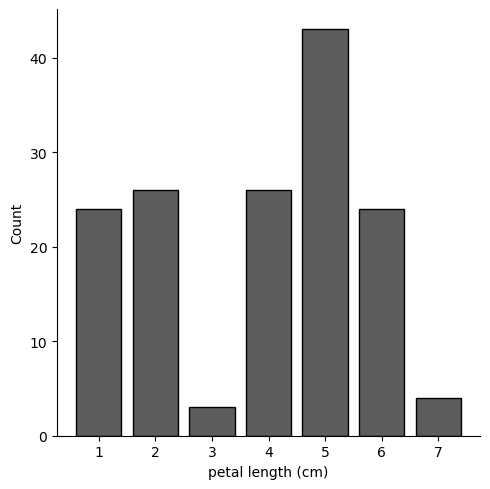

In [61]:
sns.set_palette("dark:grey")
sns.displot(irisdata, x="petal length (cm)", discrete = True, shrink =0.8)

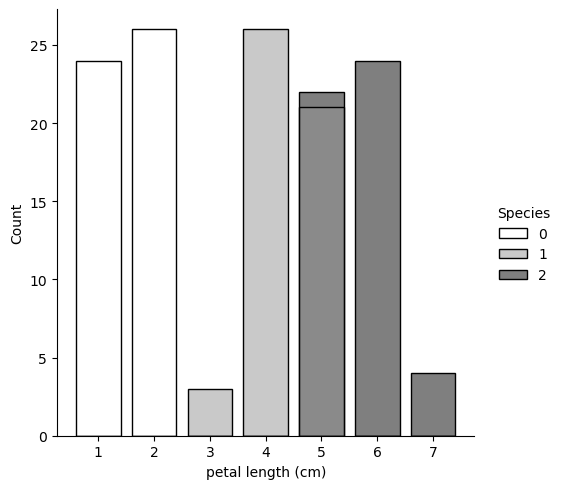

In [62]:
sns.displot(irisdata, x="petal length (cm)", discrete = True, hue = "Species", shrink =0.8, palette = "Greys")

### 4-pseudo sigma filter for continuous data

In [63]:
# Filter continuous data using a 4 pseudo sigma filter
# dataframe = pandas dataframe to modify
# parameter = name of column in dataframe to filter

def pseudosigmafilter(dataframe, parameter):
    mean = dataframe[parameter].mean()
    stdev = dataframe[parameter].std()
    lowerfiltervalue = mean - (4*stdev)
    upperfiltervalue = mean + (4*stdev)
    # print(mean)
    # print(stdev)
    # print(lowerfiltervalue)
    # print(upperfiltervalue)
    
    # Create a new column called "filter_" parameter and set to NaN if outside the limits
    dataframe["filter_" + parameter] = np.where(((dataframe[parameter] > lowerfiltervalue) & (dataframe[parameter] < upperfiltervalue)) , dataframe[parameter], np.NaN)
    return dataframe

In [64]:
# Inject a huge value in Category A and test that it is filtered
testdf.at[0,"A"] = 11

pseudosigmafilter (testdf, "A")

,A,B,C,category,Date,filter_A
0,11.000000,-0.760867,-0.644580,Category A,2023-04-16,NaN
1,1.550786,-0.455346,-1.149559,Category A,2022-12-22,1.550786
2,1.337273,1.480686,-0.712892,Category A,2023-09-29,1.337273
3,0.107457,-0.137325,0.136342,Category A,2023-09-24,0.107457
4,0.334353,1.169766,-1.943095,Category A,2022-11-25,0.334353
...,...,...,...,...,...,...
5245,-0.623680,0.938495,-0.730673,Cat C,2023-09-28,-0.623680
5246,-2.359358,-0.865432,0.190066,Cat C,2022-10-30,-2.359358
5247,0.546746,0.655188,-0.397355,Cat C,2023-08-21,0.546746
5248,-1.908304,0.705666,-0.720094,Cat C,2023-05-03,-1.908304


### Standardizing continuous data

In [73]:
from sklearn import preprocessing
continuous = testdf[["A", "B", "C"]]
continuous.head()


,A,B,C
0,11.000000,-0.760867,-0.644580
1,1.550786,-0.455346,-1.149559
2,1.337273,1.480686,-0.712892
3,0.107457,-0.137325,0.136342
4,0.334353,1.169766,-1.943095


In [74]:
standardized = preprocessing.StandardScaler().fit(continuous)

In [75]:
standardized = standardized.transform(continuous)
print (standardized)

[[10.93595772 -0.74516073 -0.64152988]
 [ 1.54261697 -0.43853796 -1.13857998]
 [ 1.33036638  1.50447629 -0.70876941]
 ...
 [ 0.54451396  0.67600127 -0.39818636]
 [-1.89601915  0.726661   -0.71585799]
 [-1.0025784  -2.62744878  0.70678435]]


In [76]:
standardizeddf = pd.DataFrame(standardized, columns=["A", "B", "C"] )
standardizeddf.head()

,A,B,C
0,10.935958,-0.745161,-0.641530
1,1.542617,-0.438538,-1.138580
2,1.330366,1.504476,-0.708769
3,0.107822,-0.119370,0.127131
4,0.333377,1.192435,-1.919657


In [77]:
standardizedtestdf = pd.concat([testdf, standardizeddf],axis=1)
standardizedtestdf.head()

,A,B,C,category,Date,filter_A,A,B,C
0,11.000000,-0.760867,-0.644580,Category A,2023-04-16,NaN,10.935958,-0.745161,-0.641530
1,1.550786,-0.455346,-1.149559,Category A,2022-12-22,1.550786,1.542617,-0.438538,-1.138580
2,1.337273,1.480686,-0.712892,Category A,2023-09-29,1.337273,1.330366,1.504476,-0.708769
3,0.107457,-0.137325,0.136342,Category A,2023-09-24,0.107457,0.107822,-0.119370,0.127131
4,0.334353,1.169766,-1.943095,Category A,2022-11-25,0.334353,0.333377,1.192435,-1.919657


#### Centering data

In [78]:
centered = preprocessing.StandardScaler(with_std=False).fit(continuous)
print(centered.transform(continuous))

[[11.00100659 -0.74248292 -0.6517629 ]
 [ 1.55179271 -0.43696203 -1.15674143]
 [ 1.33827962  1.49906981 -0.72007497]
 ...
 [ 0.54775282  0.67357199 -0.40453782]
 [-1.90729698  0.72404967 -0.72727662]
 [-1.0085419  -2.61800678  0.71805824]]


### Normalizing continuous data

In [85]:
from sklearn import preprocessing
def normalizecolumn(dataframe, parameter):
    colarray = np.array(dataframe[parameter])
    normalizedarray = preprocessing.normalize([colarray]).tolist()
    normalizedarray = np.swapaxes(normalizedarray,0,1)
    dataframe["normalized_" + parameter] = normalizedarray
    return dataframe

In [86]:
normalizecolumn(testdf, "B")

,A,B,C,category,Date,filter_A,normalized_B
0,11.000000,-0.467456,-0.644003,Category A,2023-10-23,NaN,-0.006447
1,0.317928,0.180459,-0.955891,Category A,2023-08-26,0.317928,0.002489
2,1.717734,-1.461808,1.417787,Category A,2023-03-23,1.717734,-0.020160
3,-0.205581,0.976843,0.723133,Category A,2023-09-08,-0.205581,0.013472
4,2.101230,0.369219,1.420681,Category A,2023-07-05,2.101230,0.005092
...,...,...,...,...,...,...,...
5245,-0.497334,-0.955604,-1.729412,Cat C,2023-04-03,-0.497334,-0.013179
5246,-1.216212,-1.632568,0.207243,Cat C,2022-12-16,-1.216212,-0.022515
5247,0.244406,-0.546770,-0.006604,Cat C,2023-05-27,0.244406,-0.007541
5248,0.403877,-0.634075,1.316784,Cat C,2023-01-23,0.403877,-0.008745


### Correcting spelling in a column

In [108]:
def cleancategory(dataframe, parameter):
    if parameter == "category":
        dataframe["clean_" + parameter] = "Category " + dataframe[parameter].str[-1]
    return dataframe

In [109]:
cleancategory(testdf, "category" )

,A,B,C,category,Date,filter_A,normalized_B,clean_category
0,11.000000,-0.467456,-0.644003,Category A,2023-10-23,NaN,-0.006447,Category A
1,0.317928,0.180459,-0.955891,Category A,2023-08-26,0.317928,0.002489,Category A
2,1.717734,-1.461808,1.417787,Category A,2023-03-23,1.717734,-0.020160,Category A
3,-0.205581,0.976843,0.723133,Category A,2023-09-08,-0.205581,0.013472,Category A
4,2.101230,0.369219,1.420681,Category A,2023-07-05,2.101230,0.005092,Category A
...,...,...,...,...,...,...,...,...
5245,-0.497334,-0.955604,-1.729412,Cat C,2023-04-03,-0.497334,-0.013179,Category C
5246,-1.216212,-1.632568,0.207243,Cat C,2022-12-16,-1.216212,-0.022515,Category C
5247,0.244406,-0.546770,-0.006604,Cat C,2023-05-27,0.244406,-0.007541,Category C
5248,0.403877,-0.634075,1.316784,Cat C,2023-01-23,0.403877,-0.008745,Category C


### Reformatting date data

In [85]:
testdf["Date_new"] = testdf["Date"].dt.strftime("%d-%b-%Y")
testdf.head()

,A,B,C,category,Date,filter_A,Date_new
0,11.000000,-0.760867,-0.644580,Category A,2023-04-16,NaN,16-Apr-2023
1,1.550786,-0.455346,-1.149559,Category A,2022-12-22,1.550786,22-Dec-2022
2,1.337273,1.480686,-0.712892,Category A,2023-09-29,1.337273,29-Sep-2023
3,0.107457,-0.137325,0.136342,Category A,2023-09-24,0.107457,24-Sep-2023
4,0.334353,1.169766,-1.943095,Category A,2022-11-25,0.334353,25-Nov-2022


In [86]:
testdf["Date_US"] = testdf["Date"].dt.strftime("%m/%d/%Y")
testdf.head()

,A,B,C,category,Date,filter_A,Date_new,Date_US
0,11.000000,-0.760867,-0.644580,Category A,2023-04-16,NaN,16-Apr-2023,04/16/2023
1,1.550786,-0.455346,-1.149559,Category A,2022-12-22,1.550786,22-Dec-2022,12/22/2022
2,1.337273,1.480686,-0.712892,Category A,2023-09-29,1.337273,29-Sep-2023,09/29/2023
3,0.107457,-0.137325,0.136342,Category A,2023-09-24,0.107457,24-Sep-2023,09/24/2023
4,0.334353,1.169766,-1.943095,Category A,2022-11-25,0.334353,25-Nov-2022,11/25/2022


### Sampling data for each class to match the class with the smallest number of observations

In [20]:
# Use pandas to select a random sample by category
# dataframe = pandas dataframe to modify
# category = name of column in dataframe
# nsamples = number of rows 

def subsamplecategory(olddataframe,category,nsamples):
    newdataframe = olddataframe.groupby(category).apply(lambda s: s.sample(nsamples))
    return newdataframe

In [21]:
newdf = subsamplecategory(testdf,"category",750)
print (newdf)

                        A         B         C    category
category                                                 
Category A 1788  1.156905  1.504229 -0.136987  Category A
           337  -1.523744  1.138347  0.272160  Category A
           2605 -0.385836  1.146510 -1.595837  Category A
           1925  0.728891 -1.155638 -0.105170  Category A
           1289  0.303061 -0.639206 -2.902055  Category A
...                   ...       ...       ...         ...
Category C 5166  0.235172  1.415833 -0.558965  Category C
           4750 -0.082857  1.749476 -0.534250  Category C
           4863  0.643469 -0.269273  2.014540  Category C
           5195  0.299041  0.645728  0.073747  Category C
           5150 -0.114027  1.025982  0.836535  Category C

[2250 rows x 4 columns]
